# Perfect sampling on 1d XY model 

## Hamiltonian
\begin{align}
H = -\sum_{<ij>}J_{ij}S_{i}\cdot S_{j} = -J\sum_{i=1}^{N-1}\cos{(\theta_{i}-\theta_{i+1})}，
\end{align}
where $N$ is the number of spins and we assume $J_{ij} = J$.

## 1. Free bounday condition

### Partition function：
\begin{align}
Z = (2\pi)^{N}[I_{0}(\beta J)]^{N-1}
\end{align}

### $Z_{1}$:
\begin{align}
Z_{1}(\theta_{1}) &= \int_{-\pi}^{\pi}d\theta_{2}\cdots d\theta_{N}\exp{[\beta J(\cos{(\theta_{1} - \theta_{2})} + \cos{(\theta_{2} - \theta_{3})} + \cdots + \cos{(\theta_{N-1} - \theta_{N})})]}\\
&=(2\pi)^{N-2}[I_{0}(\beta J)]^{N-2}\int_{-\pi}^{\pi}d\theta_{2}\exp{[\beta J\cos{(\theta_{1}-\theta_{2}})]}, 
\end{align}
then we get
\begin{align}
P(\theta_{1}) &= \frac{Z_{1}(\theta_{1})}{Z} = \frac{\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{1}-\theta})]}}{(2\pi)^{2} I_{0}(\beta J)}\\
&=\frac{1}{2\pi}.
\end{align}

### $Z_{2}(\theta_{1}, \theta_{2})$:
\begin{align*}
Z_{2}(\theta_{1}, \theta_{2}) &= \int_{-\pi}^{\pi}d\theta_{3}\cdots d\theta_{N}\exp{[\beta J(\cos{(\theta_{1} - \theta_{2})} + \cos{(\theta_{2} - \theta_{3})} + \cdots + \cos{(\theta_{N-1} - \theta_{N})})]} \\
&=\exp{[\beta J\cos{(\theta_{1}-\theta_{2})}]}(2\pi)^{N-3}[I_{0}(\beta J)]^{N-3}\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{2}-\theta})]},
\end{align*}
then we get
\begin{align}
P(\theta_{2}|\theta_{1}) &= \frac{Z_{2}(\theta_{1}, \theta_{2})}{Z_{1}(\theta_{1})}\\
&=\frac{\exp{[\beta J\cos{(\theta_{1}-\theta_{2})}]}\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{2}-\theta})]}}{2\pi I_{0}(\beta J)\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{1}-\theta})]}} \\
&=\frac{\exp{[\beta J\cos{(\theta_{1}-\theta_{2})}]}}{2\pi I_{0}(\beta J)}
\end{align}

### $Z_{k}(\theta_{1}, \cdots, \theta_{k})$
we can get general result by mathematical induction
\begin{align*}
Z_{k}(\theta_{1}, \cdots, \theta_{k}) &= \int_{-\pi}^{\pi}d\theta_{k+1}\cdots d\theta_{N}\exp{[\beta J(\cos{(\theta_{1} - \theta_{2})} + \cos{(\theta_{2} - \theta_{3})} + \cdots + \cos{(\theta_{N-1} - \theta_{N})})]} \\
&= \Pi_{i=1}^{k-1}\exp{[\beta J\cos{(\theta_{i}-\theta_{i+1})}]}(2\pi)^{N-(k+1)}[I_{0}(-J\beta)]^{N-(k+1)}\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{k}-\theta})]},
\end{align*}
so we have
\begin{align*}
P(\theta_{k}|\theta_{k-1},\cdots,\theta_{1}) &= \frac{\exp{[\beta J\cos{(\theta_{k-1}-\theta_{k})}]}\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{k}-\theta})]}}{2\pi I_{0}(\beta J)\int_{-\pi}^{\pi}d\theta\exp{[\beta J\cos{(\theta_{k-1}-\theta})]}} \\
&=\frac{\exp{[\beta J\cos{(\theta_{k-1}-\theta_{k})}]}}{2\pi I_{0}(\beta J)}
\end{align*}

### So the perfect sampling of the 1D XY model (free boundary condition) is as follows,
#### 1. Sample $\theta_{1}$ from 
\begin{align}
P(\theta_{1}) = \frac{1}{2\pi},
\end{align}

#### 2. Sample $\theta_{k}$ from the following distribution recursively:
\begin{align}
P(\theta_{k}|\theta_{k-1}, \cdots, \theta_{1}) = \frac{\exp{[\beta J\cos{(\theta_{k-1}-\theta_{k})}]}}{2\pi I_{0}(\beta J)}.
\end{align}

----

### Chain Sampling of 1D XY Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
import time

In [2]:
from math import cos, exp, pi
from scipy.integrate import quad

In [3]:
from scipy.special import iv
from scipy.integrate import quad

In [4]:
from sympy.solvers import solve
from sympy import Symbol

In [5]:
import timeout_decorator

In [23]:
class XY_1d_chain_sampling:
    
    def __init__(self, j=1, beta=1, length=10, n=500, err_thold=1e-10):
        self.j = j
        self.beta = beta
        self.length = length
        self.grids = np.zeros(length)
        self.I0_beta = iv(0, self.beta * self.j)
        self.err_thold = err_thold
        self.n = n
        self.aux_init()
        
    def aux_init(self):
        self.aux_vec = np.zeros(self.n)
        bj = self.beta * self.j
        for i in range(self.n):
            self.aux_vec[i] = iv(i+1, bj) / (np.pi * self.I0_beta * (i+1))
    
    def cdf_theta_i(self, theta_i, theta_j):
        n_vec = np.arange(1, self.n+1)
        aux_vec_x = np.sin(n_vec * (theta_i - theta_j)) + ((-1) ** n_vec) * np.sin(n_vec * theta_j)
        F_i = self.aux_vec.dot(aux_vec_x) + 1/2 + theta_i / (2 * pi)   
        return F_i
    
    def cdf_theta_i_create(self, theta_j):
        cdf_theta_i = lambda theta_i: self.cdf_theta_i(theta_i, theta_j)
        return cdf_theta_i
        
    def sample_theta_i(self, theta_j):
        f_theta = np.random.uniform(0, 1)
        cdf_theta_i = self.cdf_theta_i_create(theta_j)
        theta_sample = self.shooting(f_theta, cdf_theta_i)
        
        return theta_sample
    
    #def _sample_theta_i(self, theta_j):
    #    def cdf_theta_i(theta_i, theta_j):
    #        n_vec = np.arange(1, self.n+1)
    #        aux_vec_x = np.sin(n_vec * (theta_i - theta_j)) + ((-1) ** n_vec) * np.sin(n_vec * theta_j)
    #        F_i = self.aux_vec.dot(aux_vec_x) + 1/2 + theta_i / (2 * pi)   
    #        return F_i
    #    f_theta = np.random.uniform(0, 1)
    #    theta_i = Symbol('theta_i')        
    #    cdf_theta_i = cdf_theta_i(theta_i, theta_j)
    #    cdf_theta_i_equ = cdf_theta_i - f_theta
    #    theta_sample = solve(cdf_theta_i_equ, theta_i)
        
    #    return theta_sample
    
    def shooting(self, f_tg, cdf):
        theta_left, theta_right = -pi, pi
        while True: 
            theta_mid = (theta_left + theta_right) / 2.0
            if cdf(theta_mid) < f_tg - self.err_thold:
                theta_left = theta_mid
            elif cdf(theta_mid) > f_tg + self.err_thold:
                theta_right = theta_mid
            else:
                return theta_mid
        
    def sample_theta(self):
        theta_sample = np.random.uniform(-pi, pi)
        return theta_sample
    
    def sample_chain(self):
        self.grids[0] = self.sample_theta()
        for i in range(1, self.length):
            self.grids[i] = self.sample_theta_i(self.grids[i-1])
        #print("sampling is done!")
        
    def spin_viz(self, figsize=(12, 3), save=False, folder_name=None):
        fig = plt.figure(figsize=figsize)
        x, y = np.meshgrid(np.arange(0, self.length), 0)
        u = np.cos(self.grids)
        v = np.sin(self.grids)
        q = plt.quiver(x, y, u, v, scale=20, width=0.01, headlength=3, headwidth=2, headaxislength=3, minshaft=3)
        plt.axis('off')
        plt.title('T={:.3f}, spins={}'.format(1/self.beta, self.length), fontsize=20)
        if save and step is not None:
            plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
            plt.close(fig)
            
    def energy_compute_grids(self):
        energy_total = 0
        for i in range(self.length-1):
            energy_i = -self.j * np.cos(self.grids[i] - self.grids[i+1])
            energy_total += energy_i
        return energy_total
    
    def magnet_grids(self):
        magnet_x, magnet_y = 0, 0
        for i in range(self.length):
            magnet_x += np.sin(self.grids[i])
            magnet_y += np.cos(self.grids[i])
        return magnet_x, magnet_y

In [22]:
xy_1d = XY_1d_chain_sampling(beta=10, j=1, length=10, err_thold=1e-10, n=500)

In [24]:
xy_1d.sample_chain()

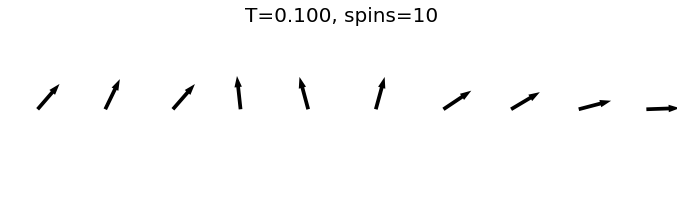

In [26]:
xy_1d.spin_viz()

In [14]:
print(f"The energy of the system is: {xy_1d.energy_compute_grids():.3f}.")

The energy of the system is: -7.201.


------

In [225]:
xy_1d = XY_1d_chain_sampling(beta=600, j=1, length=10, err_thold=1e-10, n=500)

In [226]:
### sampling stage
energy_list = []
for i in trange(1000):
    xy_1d.sample_chain()
    energy_list.append(xy_1d.energy_compute_grids())
print("iterations are done!")

  0%|          | 0/1000 [00:00<?, ?it/s]

iterations are done!


In [227]:
np.mean(energy_list)

-8.986127919443597

In [228]:
np.std(energy_list)

0.011413505066775867

In [229]:
beta_list = [i * 100 for i in range(5, 0, -1)]

In [232]:
mean_sampling_list = []
std_sampling_list = []
for i in trange(5):
    beta = beta_list[i]
    length = 10
    xy_1d = XY_1d_chain_sampling(beta=beta, j=1, length=10, err_thold=1e-10, n=500)
    # firing stage
    ### sampling stage
    energy_list = []
    for i in trange(10000):
        xy_1d.sample_chain()
        energy_list.append(xy_1d.energy_compute_grids())
    print("iterations are done!")
    mean_sampling_list.append(np.mean(energy_list))
    std_sampling_list.append(np.std(energy_list))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations are done!


In [233]:
mean_sampling_list

[-8.982870416533498,
 -8.979101665691132,
 -8.972049695276205,
 -8.957356562339559,
 -8.916173201876314]

### low temperature limit (size = 20)

In [220]:
xy_1d = XY_1d_chain_sampling(beta=100, j=1, length=20, err_thold=1e-10, n=500)

In [224]:
### sampling stage
energy_list = []
for i in trange(5000):
    xy_1d.sample_chain()
    energy_list.append(xy_1d.energy_compute_grids())
print("iterations are done!")

  0%|          | 0/5000 [00:00<?, ?it/s]

iterations are done!


In [222]:
np.mean(energy_list)

-8.912329020226176

In [223]:
np.std(energy_list)

0.07145655639864504

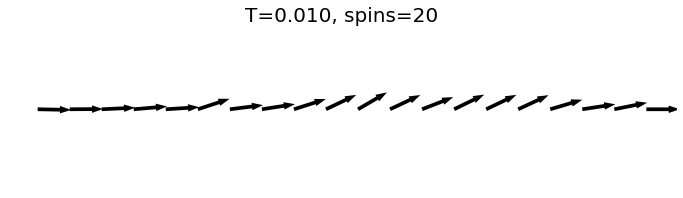

In [27]:
xy_1d.spin_viz()

In [28]:
print(f"The energy of the system is: {xy_1d.energy_compute_grids():.3f}.")

The energy of the system is: -18.871.


### low temperature limit (size = 10)

In [29]:
xy_1d = XY_1d_chain_sampling(beta=100, j=1, length=10)

In [30]:
xy_1d.sample_chain()

sampling is done!


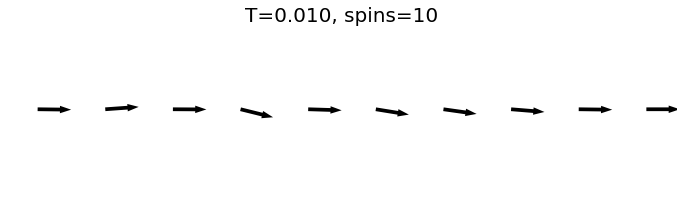

In [31]:
xy_1d.spin_viz()

In [32]:
print(f"The energy of the system is: {xy_1d.energy_compute_grids():.3f}.")

The energy of the system is: -8.931.


### low temperature limit (size = 5)

In [33]:
xy_1d = XY_1d_chain_sampling(beta=100, j=1, length=5)

In [34]:
xy_1d.sample_chain()

sampling is done!


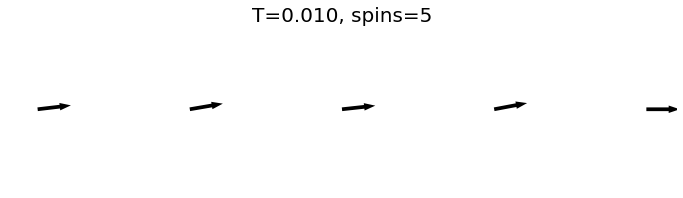

In [35]:
xy_1d.spin_viz()

In [36]:
print(f"The energy of the system is: {xy_1d.energy_compute_grids():.3f}.")

The energy of the system is: -3.977.


### Beta = 200

In [41]:
# initialize the 1d xy model
xy_1d = XY_1d_chain_sampling(beta=200, j=1, length=10)

In [42]:
time_start = time.time()
xy_1d.sample_chain()
time_end = time.time()
print('it costs us: {time_end - time_start}.')

sampling is done!


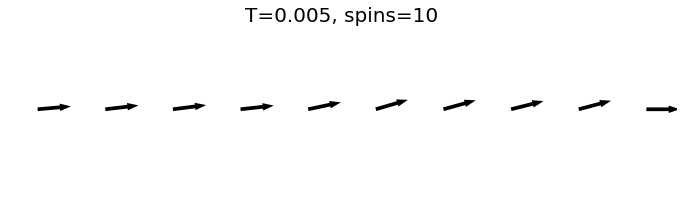

In [43]:
xy_1d.spin_viz()

In [44]:
print(f"The energy of the system is: {xy_1d.energy_compute_grids():.3f}.")

The energy of the system is: -8.958.


In [53]:
# initialize the 1d xy model
xy_1d = XY_1d_chain_sampling(beta=350, j=1, length=10)

In [55]:
time_start = time.time()
xy_1d.sample_chain()
time_end = time.time()
print(f'it costs us: {time_end - time_start}.')

sampling is done!
it costs us: 108.03134369850159.


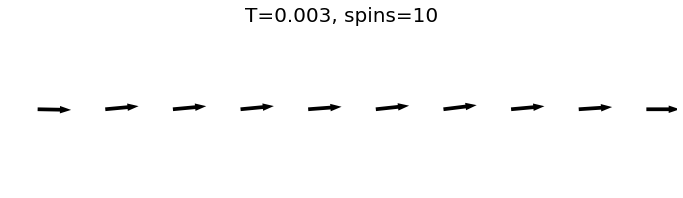

In [56]:
xy_1d.spin_viz()

-------
### Compute the Energy of the system at different temperatures

In [27]:
temp_list = [0.1 + 0.5 * i for i in range(10)]
beta_list = [1 / temp for temp in temp_list]
length = 5

In [28]:
energy_mean_list, energy_std_list = [], []
for i in trange(10):
    beta = beta_list[i]
    xy_1d = XY_1d_chain_sampling(beta=beta, j=1, length=length, err_thold=1e-15, n=500)
    energy_list = []
    for i in trange(10000):
        xy_1d.sample_chain()
        energy_list.append(xy_1d.energy_compute_grids() / length)
    energy_mean_list.append(np.mean(energy_list))
    energy_std_list.append(np.std(energy_list))
    print(f"iterations of beta={beta} are done!")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=10.0 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=1.6666666666666667 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.9090909090909091 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.625 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.47619047619047616 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.3846153846153846 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.3225806451612903 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.2777777777777778 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.24390243902439027 are done!


  0%|          | 0/10000 [00:00<?, ?it/s]

iterations of beta=0.2173913043478261 are done!


In [29]:
energy_mean_list

[-0.758574747702075,
 -0.5040699045179287,
 -0.3271703671076833,
 -0.23785818287632532,
 -0.1835510434168017,
 -0.15253556531141002,
 -0.1247792394078079,
 -0.10931781259435704,
 -0.10041976197875697,
 -0.08946341572242628]

In [30]:
energy_std_list

[0.029273270051512316,
 0.1874473914281641,
 0.24567489957188254,
 0.26706932103145803,
 0.26976978569696597,
 0.27429085113533463,
 0.279309906437383,
 0.27727278642847875,
 0.2786340536018883,
 0.28168315284415396]

-----
### Size = 20

In [32]:
temp_list = [0.1 + 0.5 * i for i in range(10)]
beta_list = [1 / temp for temp in temp_list]
length = 20

In [ ]:
energy_mean_list, energy_std_list = [], []
for i in trange(10):
    beta = beta_list[i]
    xy_1d = XY_1d_chain_sampling(beta=beta, j=1, length=length, err_thold=1e-15, n=500)
    energy_list = []
    for i in trange(5000):
        xy_1d.sample_chain()
        energy_list.append(xy_1d.energy_compute_grids() / length)
    energy_mean_list.append(np.mean(energy_list))
    energy_std_list.append(np.std(energy_list))
    print(f"iterations of beta={beta} are done!")

In [36]:
def energy_by_z(beta, j, size):
    energy = -(size - 1) * j / iv(0, beta*j) * iv(-1, beta*j) 
    energy_per_spin = energy / size
    return energy_per_spin

In [37]:
energy_z_list = []
for beta in beta_list:
    energy_z_list.append(energy_by_z(beta, 1, length))

In [39]:
energy_mean_list

[-0.9012997436467048,
 -0.6019912931431447,
 -0.3972737702528436,
 -0.2823090762247251,
 -0.22002074450645215,
 -0.17812211175626178,
 -0.15111263960841284,
 -0.13151942270130962,
 -0.11302896369241253,
 -0.10149725938429828]

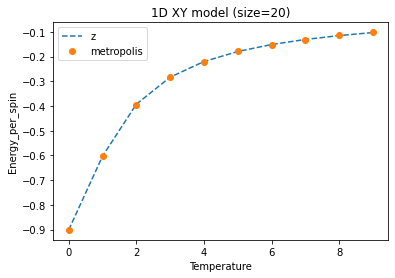

In [38]:
plt.plot(energy_z_list, '--', label='z')
plt.plot(energy_mean_list, 'o', label='metropolis')
plt.xlabel('Temperature')
plt.ylabel('Energy_per_spin')
plt.title('1D XY model (size=20)')
plt.legend()